In [1]:
%load_ext autoreload
%autoreload 2

# Inference:

This notebook evaluates the trained model on the test set. This is done for the on-day-ahead prediction the model has been trained for as well as a 14-day forecast
Steps covered 

* single-day prediction
* 14-days forecast
* result evaluation for the predicted time series of 14 days

In [2]:
import warnings
import pandas as pd

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

In [3]:
from fashion_sales_forecast.model import load_model

model = load_model()

In [4]:
from fashion_sales_forecast.features import load_selected_features

selected_features = load_selected_features()

## Evaluate 1-day forecast on test set
This is an evaluation analoguos to the situation during training.

In [5]:
import joblib
import pandas as pd
from sklearn.metrics import mean_squared_error
from fashion_sales_forecast import config

pd.options.mode.chained_assignment = None

feature_preparation_pipeline = joblib.load(
    f"{config.MODEL_ARTIFACT_PATH}/feature_preparation_pipeline.pkl"
)
df_test = feature_preparation_pipeline.transform(
    pd.read_parquet(f"{config.DATA_PATH}/test.parquet")
)

df_test["model_prediction"] = model.predict(df_test[selected_features])

In [6]:
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

from fashion_sales_forecast import config

y_pred = df_test["model_prediction"]
y_true = df_test[config.LABEL_COLUMN]

mae = mean_absolute_error(y_true, y_pred)
mse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true[y_true > 0], y_pred[y_true > 0]) * 100

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAPE: {mape:.3f}%")

MAE: 2.805
MSE: 4.510
MAPE: 44.023%


## Make 14 day prediction
We use the one-day-ahead prediction model to do consecutive predictions in order to reach the forecast horizon of 14 days. Alternatively, we could train a sequence-to-sequence model.

It is important to pay special attention to the update of lagged features, as some of them might not be present for during prediction in the intermediate future. In order to do this, the lagged features are replaces by earlier predictions when necessary.

In [7]:
from fashion_sales_forecast.evaluate import create_future_labels

df_test = create_future_labels(df_test, days_in_future=14)

In [8]:
from fashion_sales_forecast.evaluate import predict_several_days

df_result = predict_several_days(df_test, model, selected_features, n_days=14)

## Result

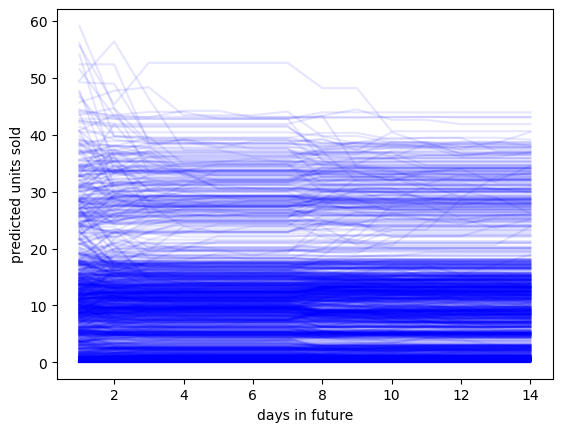

In [9]:
import matplotlib.pyplot as plt

df_prediction = df_result.filter(
    items=[col for col in df_result.columns if col.startswith("predict")]
)
y = np.transpose(df_prediction.values)
x = range(1, 14 + 1)

plt.plot(x, y, color="blue", alpha=0.1)
plt.xlabel(r"days in future")
plt.ylabel(r"predicted units sold")
plt.show()

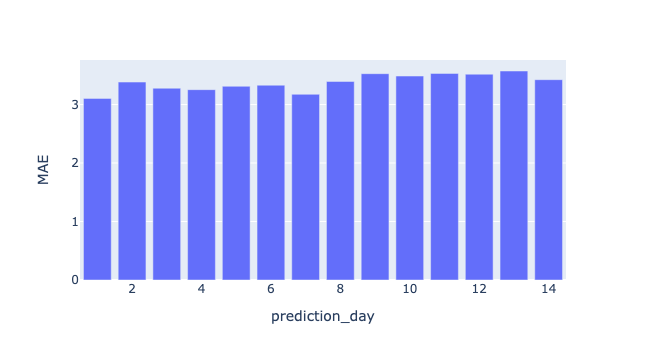

MAE  prediction_day
0   3.105423               1
1   3.384125               2
2   3.279072               3
3   3.254456               4
4   3.312057               5
5   3.330470               6
6   3.174952               7
7   3.394569               8
8   3.527661               9
9   3.487124              10
10  3.532206              11
11  3.518787              12
12  3.573481              13
13  3.425111              14

In [10]:
import plotly.express as px
from fashion_sales_forecast.evaluate import compute_time_dependent_metric


df_metric = compute_time_dependent_metric(df_result, n_days=14)

fig = px.bar(df_metric, x="prediction_day", y="MAE")
fig.show()
display(df_metric)